## Introduction
This is adjust from the `test2.ipynb`, which is used to proof that the specific column of the Pearson's covariance matrix can be calculated column by column from $x$. 

#### Formula
Assume $X$ is an centered O/E matrix, $std$ is the standard deviation of $X$, $n$ is the length of $X[0]$.

* Pearson matrix: $A = \frac{1}{std} \frac{1}{n}X X^{T}$
* The Covariance matrix of the Pearson matrix: $\frac{1}{n} (\frac{1}{std} \frac{1}{n}X X^{T} - C)(\frac{1}{std} \frac{1}{n}X X^{T}  - C)^{T}$, where the $C$ is the mean of the Pearson matrix.

In [34]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
from hicpep import peptools
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)
np.set_printoptions(threshold=10)
# np.random.seed(20)

def flip_tracks(track1_np: np.ndarray, track2_np: np.ndarray):
    a = track1_np[~np.isnan(track1_np)]
    b = track2_np[~np.isnan(track2_np)]
    cos_sim = dot(a, b) / (norm(a) * norm(b))

    if cos_sim < 0:
        track2_np = -track2_np

    return track1_np, track2_np

### Simulated Sample

In [35]:
def generate_X(n:int):
    # Create a nxn array with random positive values
    matrix_np = np.abs(np.random.randn(n, n))  # Use absolute values for positive entries
    # Make the array symmetric
    matrix_np = matrix_np + matrix_np.T
    matrix_np = matrix_np.astype("float64") # Sparse
    return matrix_np 

X = generate_X(n=30) # Generate a n*n simulated O/E matrix.

###
# pearson_path = "/media/jordan990301/Samsung_T5/HiC_Datasets/data_for_hicpep/data_store/data/rao_2014/juicer_outputs/k562/1000000/pearsons/pearson_chr10.txt"
# X = peptools.read_pearson(pearson=pearson_path)
# diag = np.diag(X)
# diag_valid = ~np.isnan(diag)
# ixgrid = np.ix_(diag_valid, diag_valid) # Record the position of the valid sub-matrix.
# X = X[ixgrid] 
###

X -= X.mean(axis=1, keepdims=True) # Center the X.
n = len(X[0])
std = np.std(X, axis=1)
std = np.array([std]).flatten()

corr = np.corrcoef(X)
corr -= corr.mean(axis=1, keepdims=True)
corr_cov = np.cov(corr, bias=True)

# Carry out the PCA on the Pearson matrix.
pca = PCA(n_components=1)
pca.fit(np.corrcoef(X))
pc1_np = pca.components_[0]

print(corr_cov, '\n')
print(f"Explained variance ratio of the PC1: {pca.explained_variance_ratio_[0]}")

[[ 0.06879 -0.01922  0.00755 ... -0.01358  0.01221  0.02857]
 [-0.01922  0.06144 -0.0222  ... -0.00542  0.00054 -0.00936]
 [ 0.00755 -0.0222   0.05195 ... -0.01009 -0.00163 -0.00485]
 ...
 [-0.01358 -0.00542 -0.01009 ...  0.07236 -0.00631  0.00902]
 [ 0.01221  0.00054 -0.00163 ... -0.00631  0.05993  0.00273]
 [ 0.02857 -0.00936 -0.00485 ...  0.00902  0.00273  0.06635]] 

Explained variance ratio of the PC1: 0.16549775506778744


In [36]:
print("std", '\n')
print(std)
print(std.shape)

std 

[0.94095 0.69783 1.07644 ... 0.82101 0.94175 0.9008 ]
(30,)


Plot the Pearson matrix.

Text(0.5, 1.0, 'This is the heatmap of the Pearson matrix')

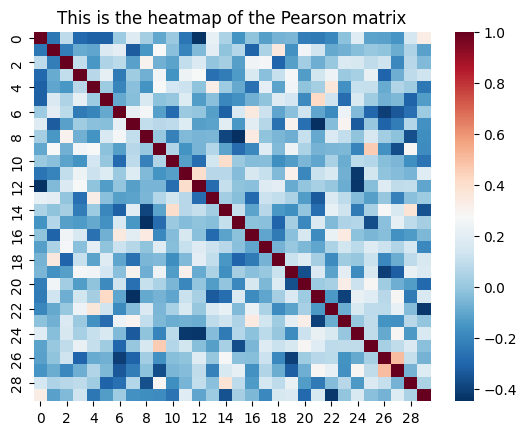

In [37]:
ax = plt.axes()
sns.heatmap(np.corrcoef(X), ax=ax, cmap="RdBu_r")
ax.set_title(f'This is the heatmap of the Pearson matrix')

In [38]:
index_s = 1 # The target column (or row) in the Pearson's covariance matrix.
corr_s = (X @ X[index_s].T / (std[index_s] * std)) / n # The target column (or row) in the Pearson matrix.
corr_s -= corr_s.mean()
print(corr_s, '\n')
print(corr_s.shape)
print("=====\n")
print(corr[index_s], '\n')
print(corr[index_s].shape)

[-0.26086  0.98526 -0.23827 ... -0.09435  0.03764 -0.12861] 

(30,)
=====

[-0.26086  0.98526 -0.23827 ... -0.09435  0.03764 -0.12861] 

(30,)


In [39]:
cov_s = []

for i in range(n):
    corr_i = (X @ X[i].T / (std[i] * std)) / n # Calculate the other columns in the Pearson matrix one by one. 
    corr_i -= corr_i.mean()
    entry = corr_i @ corr_s / n # Calculate each entry of the target column (or row) in the Pearson's covariance matrix.
    cov_s.append(entry)

cov_s = np.array(cov_s)

# Finally, these two tracks should be exactly the same.
print(corr_cov[index_s], '\n')
print(cov_s, '\n')

[-0.01922  0.06144 -0.0222  ... -0.00542  0.00054 -0.00936] 

[-0.01922  0.06144 -0.0222  ... -0.00542  0.00054 -0.00936] 



### Find the best track and plot

In [40]:
max = 0
est_np = np.array([]) 

for k in range(n):
    index_s = k # The target column (or row) in the Pearson's covariance matrix.
    corr_s = (X @ X[index_s].T / (std[index_s] * std)) / n # The target column (or row) in the Pearson matrix.
    corr_s -= corr_s.mean()
    cov_s = []

    for i in range(n):
        corr_i = (X @ X[i].T / (std[i] * std)) / n # Calculate the other columns in the Pearson matrix one by one. 
        corr_i -= corr_i.mean()
        entry = corr_i @ corr_s / n # Calculate each entry of the target column (or row) in the Pearson's covariance matrix.
        cov_s.append(entry)

    cov_s = np.array(cov_s)
    track_sum_abs = np.sum(np.abs(cov_s))

    if track_sum_abs > max:
        max = track_sum_abs
        est_np = cov_s.copy()

similar_rate: 0.8


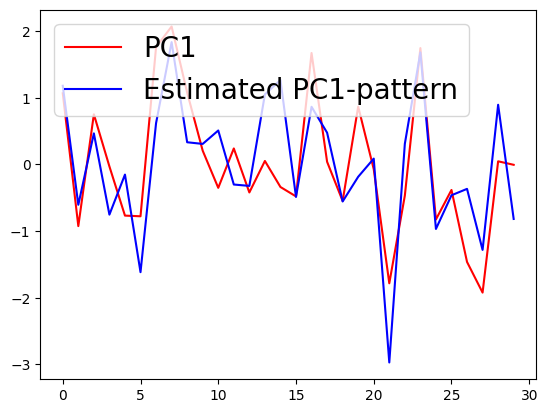

In [41]:
pc1_np, est_np = flip_tracks(track1_np=pc1_np, track2_np=est_np)
similarity_info = peptools.calc_similarity(track1_np=pc1_np, track2_np=est_np)
total_entry_num = similarity_info["total_entry_num"]
valid_entry_num = similarity_info["valid_entry_num"]
similar_num = similarity_info["similar_num"]
similar_rate = similarity_info["similar_rate"]

print(f"similar_rate: {similar_rate}")

# Z-score Normalization
est_np_norm = (est_np - np.mean(est_np)) / np.std(est_np)
pc1_np_norm = (pc1_np - np.mean(pc1_np)) / np.std(pc1_np)

plt.plot(pc1_np_norm, c='r')
plt.plot(est_np_norm, c='b')
plt.legend(["PC1", "Estimated PC1-pattern"], fontsize="20", loc ="upper left")